# 12.3. Monte Carlo simulation of the 2D Ising model

We consider a 2D Ising model with the partition function:
$$ Z = \sum_{ \{s_x = \pm 1  \} } exp \biggl[-\dfrac{\beta}{2} \sum_{n.n.} (1 - s_x s_y) \biggl] $$
For every latice site x, the interaction term only involves the four nearest neighbours y on adjacent lattice sites. Use a $N = 32^2$ lattice with periodic boundary conditions.
We have the goal to measure the average magnetization:
$$ <|M|> \ = \ <| \dfrac{1}{N} \sum_x s_x |> $$
in thermal equilibrium for different values of $\beta$, namely $\beta$ = 1.6, 1.3, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.4, 0.1. <br> <br>

a) For each value of $\beta$, go through the lattice in red-black order for at least 3000 times to establish thermalization. At each encountered lattice site x, calculate the interaction energies $E_+$ and $E_−$ for the spin up and the spin down directions of x, respectively. Then choose for the site the spin-up direction with the heat bath (Gibbs sampling) probability: 
$$p_+ = \dfrac{exp(-\beta E_+)}{exp(-\beta E_+) + exp(-\beta E_-)}$$
and the spin-down direction correspondingly with probability $p_− = 1 − p_+$. <br>

b) After the thermalization period, take measurements of M after at least 1000 full mesh sweeps and calculate the average $⟨|M|⟩$. Report this in a table for each $\beta$. <br>

c) Plot ⟨|M|⟩ as a function of $T \ \alpha \ 1/\beta$. We note that this model has a phase transition at a critical $\beta_c = log(1 + T_c \ 1/\beta_c)$. Below this temperature (i.e. for $\beta > \beta_c$), the systems shows spontaneous magnetization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import convolve2d

In [2]:
# define different values of beta
betas = [1.6, 1.3, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.47, 0.45, 0.43, 0.4, 0.3, 0.2, 0.1]

# define number of lattice points for each side
N = 32

# define n.n. kernel
nn = np.array(([0., 1., 0.], [1., 0., 1.], [0., 1., 0.]))

# define total number of thermalization steps
Q = 3000

# define total number of measurement points
T = 1000

# set seed for reproducibility
np.random.seed(30091996)

# define red-black mask
red = np.arange( (N+2)*(N+2) ).reshape(N+2,-1)
red = (red % 2) + (red % 2).T
red = (red % 2).astype(bool)
black = np.logical_not(red)

In [3]:
# compute Gibbs probability
def gibbs(Eplus, beta):
    return np.exp(- beta * Eplus) / (np.exp(- beta * Eplus) + np.exp(beta * Eplus))

# implement periodic boundary conditions
def boundcond(s):
    s[:,0] = s[:,-2]
    s[:,-1] = s[:,1]
    
    s[0,:] = s[-2,:]
    s[-1,:] = s[1,:]
    
# implement mesh sweep
def meshsweep(s, beta, full=True):
    # generate random numbers
    ran = np.random.rand(N+2, N+2)
    
    # compute spin-up energy of each site
    Eplus = - convolve2d(s, nn, mode='same')
    
    # compute spin-up prob for each site
    probs = gibbs(Eplus, beta)
    
    # full mesh sweep
    if full:
        s_out = (probs>ran).astype(int) * 2 - 1
        
    # red-black order mesh sweep
    else:
        # flip only (0,1),(0,3),..
        temp_s = (probs>ran).astype(int) * 2 - 1
        s_out = s * red + temp_s * black
        boundcond(s_out)
        
        # repeat same steps
        Eplus = - convolve2d(s_out, nn, mode='same')
        probs = gibbs(Eplus, beta)
        
        # then flip (0,0),(0,2),..
        temp_s = (probs>ran).astype(int) * 2 - 1
        s_out = s_out * black + temp_s * red
    
    boundcond(s_out)
    
    return s_out

In [4]:
# create grid with random initialization
# add 2 ghost cells for each dimension
s0 = np.random.rand( N+2, N+2 )
s0 = (s0>0.5).astype(int) * 2 - 1
boundcond(s0)

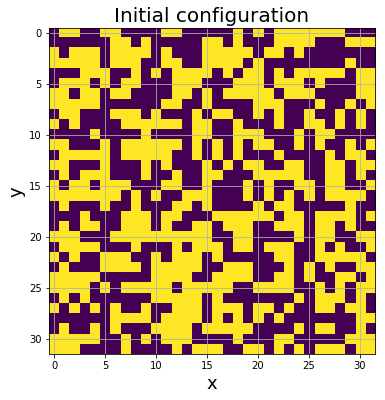

In [5]:
# show initial configuration
fig1 = plt.subplots(figsize=[12,6])
plt.imshow(s0[1:-1, 1:-1], vmin=-1., vmax=1.)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.grid()
plt.title('Initial configuration', fontsize=20)
plt.show(fig1)

### a)

In [6]:
# implement thermalization
def thermalization(s_in, beta, steps=Q):
    print('Run thermalization for beta = {:.2f}'.format(beta))
    
    # create empty matrix
    s = np.zeros((steps+1,N+2,N+2))
    
    # set initial condition
    s[0,:,:] = s_in
    
    # loop over steps
    for i in range(steps):
        s[i+1,:,:] = meshsweep(s[i,:,:], beta, full=False)
        
    return s

In [7]:
# run thermalization for every beta
s_therm = np.zeros((len(betas),Q+1, N+2, N+2 ))

for i,beta in enumerate(betas):
    s_therm[i] = thermalization(s0, beta)

Run thermalization for beta = 1.60
Run thermalization for beta = 1.30
Run thermalization for beta = 1.10
Run thermalization for beta = 1.00
Run thermalization for beta = 0.90
Run thermalization for beta = 0.80
Run thermalization for beta = 0.70
Run thermalization for beta = 0.60
Run thermalization for beta = 0.50
Run thermalization for beta = 0.47
Run thermalization for beta = 0.45
Run thermalization for beta = 0.43
Run thermalization for beta = 0.40
Run thermalization for beta = 0.30
Run thermalization for beta = 0.20
Run thermalization for beta = 0.10


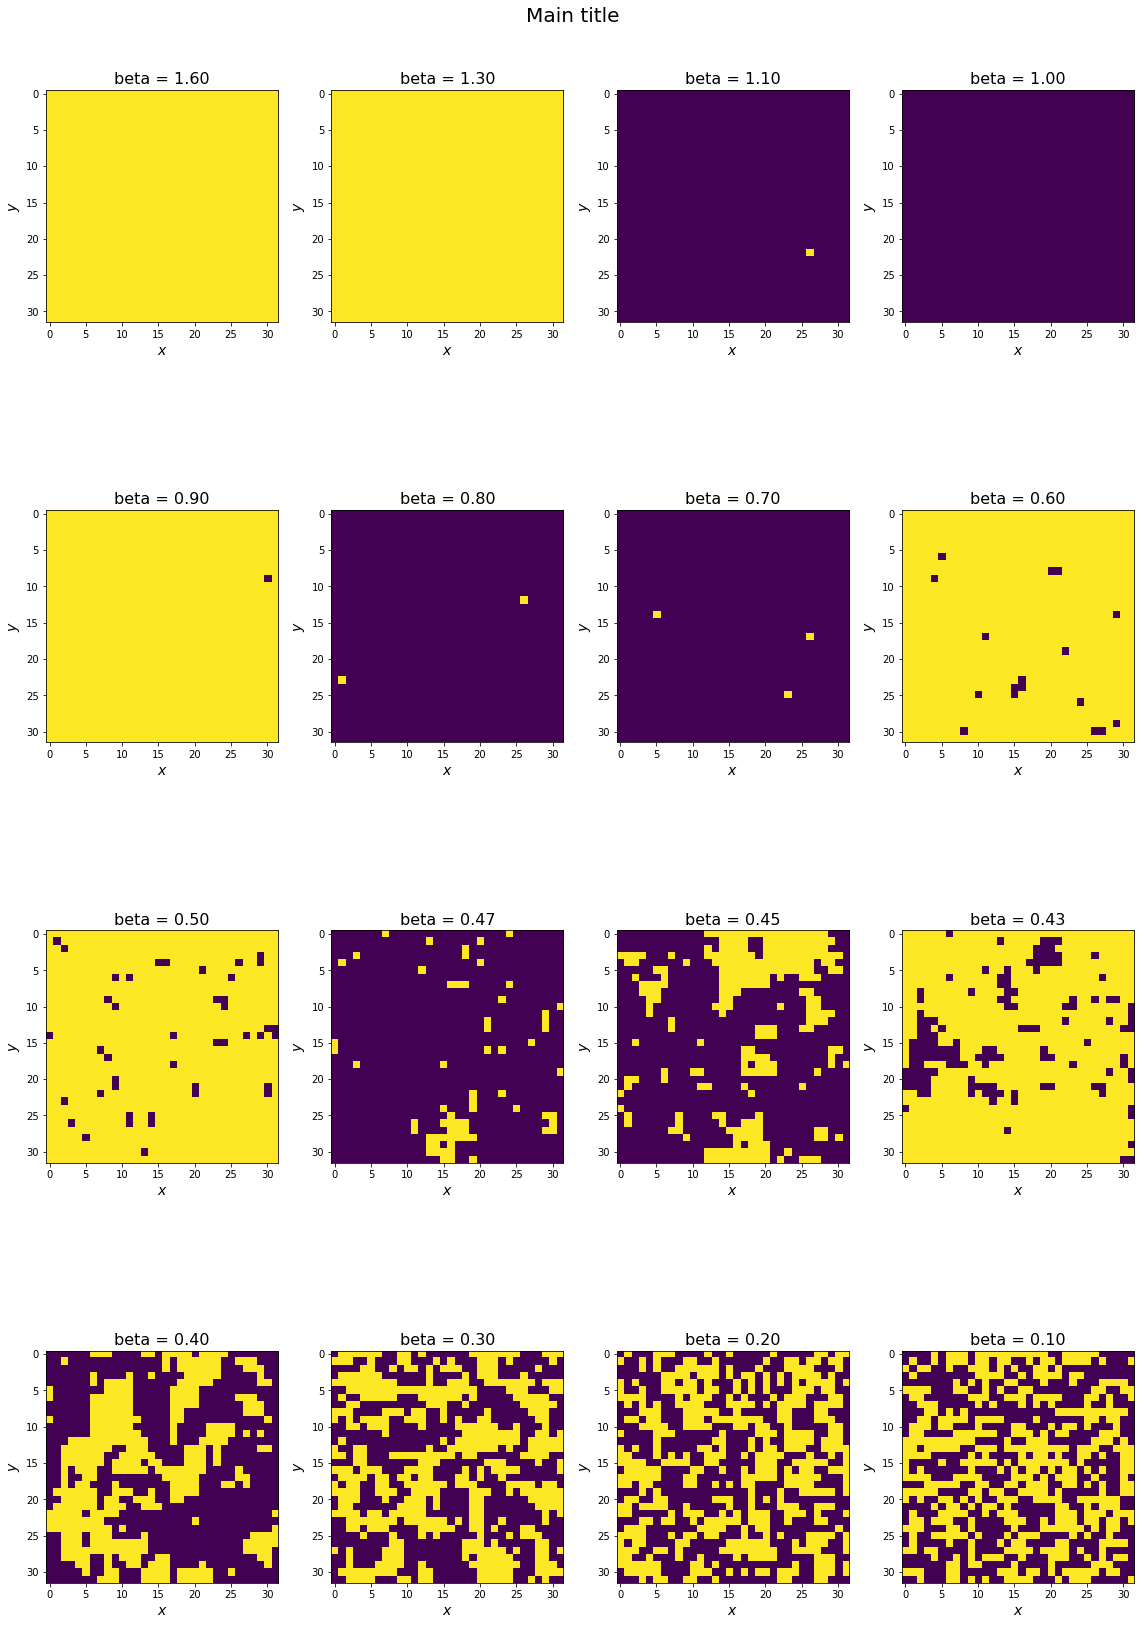

In [8]:
fig, ax = plt.subplots(int(len(betas)/4),4)
fig.set_size_inches(16,24)
fig.suptitle('Configurations after thermalization', fontsize=20)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].imshow(s_therm[4*i+j,-1, 1:-1, 1:-1], vmin=-1., vmax=1.)
        ax[i,j].set_xlabel('$x$', fontsize=14)
        ax[i,j].set_ylabel('$y$', fontsize=14)
        ax[i,j].set_title('beta = {:.2f}'.format(betas[4*i+j]), fontsize=16)

fig.tight_layout()
plt.show()

In [9]:
# show temporal evolution of thermalization process
'''
for i in range(0,M,300):
    plt.imshow(s[8,i, 1:-1, 1:-1], vmin=-1., vmax=1. )
    plt.show()
'''

'\nfor i in range(0,M,300):\n    plt.imshow(s[8,i, 1:-1, 1:-1], vmin=-1., vmax=1. )\n    plt.show()\n'

### b)

In [10]:
# compute temporal evolution of magnetisation profile
def evalmag(s_in, beta, steps=T):
    print('Compute magnetisation for beta = {:.2f}'.format(beta))
    
    # create empty matrix
    s = np.zeros((steps+1,N+2,N+2))
    
    # set initial condition
    s[0,:,:] = s_in
    
    # loop over steps
    for i in range(steps):
        s[i+1,:,:] = meshsweep(s[i,:,:], beta)
    
    # compute mean mangetisation
    M = np.mean(s, axis=2)
    M = np.mean(M, axis=1)
    
    return np.abs(M)

In [11]:
# measurement of magnetisation
M = np.zeros((len(betas), T+1 ))

for i,beta in enumerate(betas):
    M[i] = evalmag(s_therm[i,-1], beta)

Compute magnetisation for beta = 1.60
Compute magnetisation for beta = 1.30
Compute magnetisation for beta = 1.10
Compute magnetisation for beta = 1.00
Compute magnetisation for beta = 0.90
Compute magnetisation for beta = 0.80
Compute magnetisation for beta = 0.70
Compute magnetisation for beta = 0.60
Compute magnetisation for beta = 0.50
Compute magnetisation for beta = 0.47
Compute magnetisation for beta = 0.45
Compute magnetisation for beta = 0.43
Compute magnetisation for beta = 0.40
Compute magnetisation for beta = 0.30
Compute magnetisation for beta = 0.20
Compute magnetisation for beta = 0.10


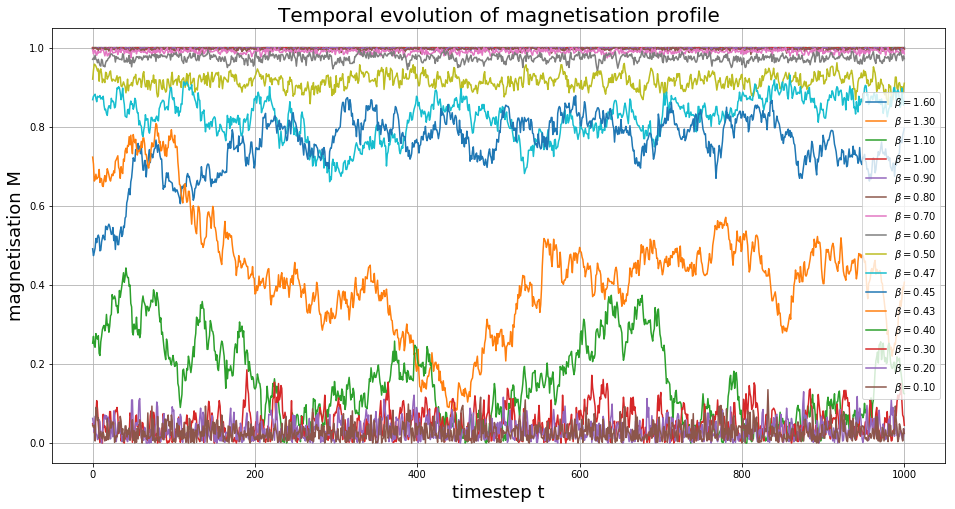

In [12]:
# plot magnetisation profiles for different beta
fig1 = plt.subplots(figsize=[16,8])

for i,beta in enumerate(betas):
    plt.plot(np.arange(T+1), M[i,:], label=r'$\beta = {:.2f}$'.format(beta))
plt.xlabel('timestep t', fontsize = 18)
plt.ylabel('magnetisation M', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Temporal evolution of magnetisation profile', fontsize=20)
plt.show(fig1)

### c)

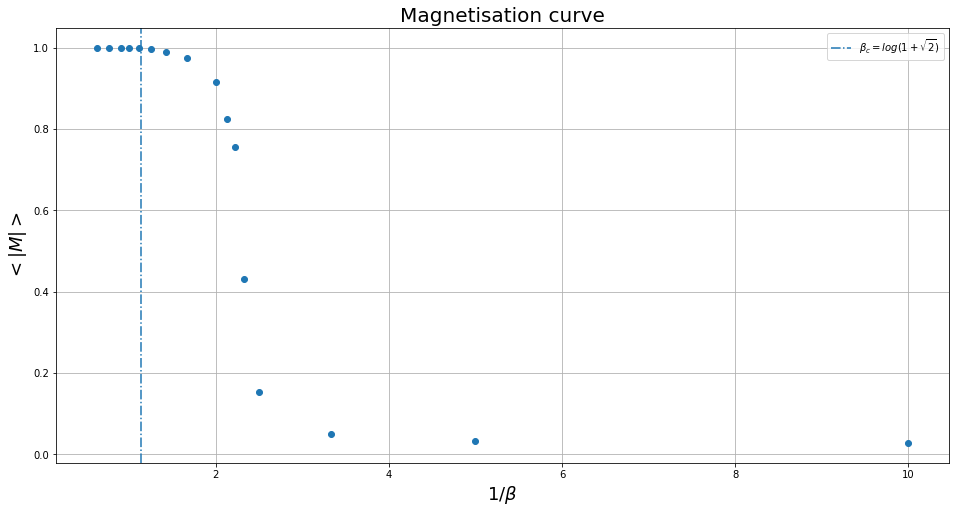

In [13]:
# compute mean values of magnetisation
M_mean = np.mean(M, axis=1)

# plot magnetisation curve
fig1 = plt.subplots(figsize=[16,8])

plt.plot(1./np.array(betas), M_mean, 'o')
plt.xlabel(r'$1/\beta$', fontsize = 18)
plt.ylabel(r'$<|M|>$', fontsize = 18)
plt.axvline(x=1./np.log(1+np.sqrt(2)), ls='-.', label=r'$\beta_c = log(1 + \sqrt{2})$')
plt.grid()
plt.legend()
plt.title('Magnetisation curve', fontsize=20)
plt.show(fig1)